In [1]:
# Choose GPU for training (optional)
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# Features that can determine the similarity between short (10s) midi files:
'''
------------------------- FEATURES FOR EVALUATING FILES SIMILARITY ---------------------------------
    
    1
    # empirical estimate of its global tempo
    # max probab Based on “Automatic Extraction of Tempo and Beat from Expressive Performance”, Dixon 2001
    midi_data.estimate_tempo()
    
    2 - NOT USED
    estimate beat start
    midi_data.estimate_beat_start()
    
    3
    onset: beginning of a musical note or other sound
    times of all onsets (in s) of all notes from all instruments. May have duplicate entries
    midi_data.get_onsets()
    
    4
    histogram of pitches (notes) [cov, var, std, mean, av, median, perc, ptp, max, min]
    midi_data.get_pitch_class_histogram()
    
    5
    transition of pitches [cov, var, std, mean, av, median, perc, ptp, max, min]
    12x12 matrix when there's a silence > time_thresh
    midi_data.get_pitch_class_transition_matrix()
    
    6
    total velocity
    total_velocity = sum(sum(midi_data.get_chroma()))
    
    7
    proxy for key: relative amount of each semitone
    Compute the relative amount of each semitone across the entire song, a proxy for key
    print([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])
    
    print('\n')
    --------------------------------------- ANALYSIS -----------------------------------------
    
    1
    tempo()
    
    2
    beat_start()
    
    3
    get_onsets()
    
    4
    pitch
    
    5
    pitch_transition
    
    6
    total velocity
    
    7
    key: relative amount of each semitone
'''
import pretty_midi
import os
import numpy as np
import pandas as pd
from music21 import midi

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
import tensorflow as tf
import matplotlib.pyplot as plt

# Load libraries
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.utils import class_weight
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, classification_report

from IPython.display import Image  
import pydotplus

Using TensorFlow backend.
/home/pablo/miniconda3/envs/ai37/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
# initialize list of lists
# Each entry corresponds to a pair of songs of the training data for similarity evaluation
# 1 means the pair with name structure ...number_1.midi and ...number_3.midi are non-similar
# 0 means the pair is similar

# The goal is train a model to distinguish whether a new pair of songs is similar or not

# All the songs have been manually labelled by me
data =  [
 ['00497eac10a66f9ab0f4b2b1cab75195_19441.midi_0_1.midi', 1],
 ['04c4330daf5279b9b33200075fa0837a_17641.midi_9_1.midi', 1],
 ['09aed5c312bff121c373e849af39f15c_11236.midi_6_1.midi', 1],
 ['0a088b58f5924caea0b1ecff3f39a6fe_4726.midi_6_1.midi', 1],
 ['0ac9dd1c27a0363cf2672924cc3df47d_21148.midi_15_1.midi', 0],
 ['0addb8ef21c3f6779009058dd2d96c78_5040.midi_9_1.midi', 0],
 ['0b79c1cbe957b992dec2aba47cc08ec9_6004.midi_0_1.midi', 1],
 ['0b79c1cbe957b992dec2aba47cc08ec9_6004.midi_4_1.midi', 0],
 ['0bb8f4fc16294bf3094669844e33569a_1073.midi_7_1.midi', 0],
 ['0bb8f4fc16294bf3094669844e33569a_17917.midi_12_1.midi', 0],
 ['0bb8f4fc16294bf3094669844e33569a_17917.midi_1_1.midi', 0],
 ['16a9b1760c034f6100e39e4f97a6c6fa_9513.midi_4_1.midi', 0],
 ['16c6b201783be17abeb8a46edd404c44_3268.midi_2_1.midi', 0],
 ['16f9df2a4cfb32f2704b8cebb06bed71_387.midi_2_1.midi', 0],
 ['17b8b864d880d7f5492e3c79740b925c_17909.midi_2_1.midi', 1],
 ['18be93639f6a2539f18f12c44e864de6_856.midi_5_1.midi', 1],
 ['18d2e82c361e5d376fa403be93840d00_8574.midi_1_1.midi', 0],
 ['193c81d7ae32045ce26ec443e7fb1069_1464.midi_6_1.midi', 1],
 ['20e37426a709c37939df1a117a038da1_836.midi_20_1.midi', 0],
 ['211a38dac4a21c383eb8aa7500876dbb_18537.midi_5_1.midi', 1],
 ['21a5933bcf653418e41276713ef34e6c_20826.midi_7_1.midi', 0],
 ['21d2123e7692d2bdfde6bf4bcba692db_12922.midi_11_1.midi', 0],
 ['21d2123e7692d2bdfde6bf4bcba692db_16160.midi_12_1.midi', 0],
 ['21d2123e7692d2bdfde6bf4bcba692db_16911.midi_14_1.midi', 0],
 ['21d2123e7692d2bdfde6bf4bcba692db_18225.midi_14_1.midi', 0],
 ['21d2123e7692d2bdfde6bf4bcba692db_1840.midi_6_1.midi', 0],
 ['21d2123e7692d2bdfde6bf4bcba692db_9609.midi_3_1.midi', 1],
 ['223a1b99d765a423880e00901a5fa71e_3480.midi_3_1.midi', 0],
 ['291c689108f59561b6e37a9aae91aa68_2875.midi_16_1.midi', 0],
 ['2de41ab084f34390266e0144397aa1c6_12062.midi_7_1.midi', 1],
 ['2de41ab084f34390266e0144397aa1c6_12062.midi_8_1.midi', 1],
 ['2de41ab084f34390266e0144397aa1c6_12062.midi_9_1.midi', 1],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_0_1.midi', 0],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_17_1.midi', 0],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_18_1.midi', 0],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_19_1.midi', 0],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_1_1.midi', 0],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_20_1.midi', 0],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_2_1.midi', 0],
 ['2e690364b9409ee1d3f25be8266e9570_3.midi_3_1.midi', 0],
 ['386d488ea19bef0dbbbb76ce14b2b725_12485.midi_4_1.midi', 1],
 ['3a44ff379436cff87840aec33ab6ecf0_1490.midi_14_1.midi', 0],
 ['3a44ff379436cff87840aec33ab6ecf0_1490.midi_17_1.midi', 0],
 ['3a44ff379436cff87840aec33ab6ecf0_1490.midi_19_1.midi', 0],
 ['3bad77c0db7a79546b57a6b2cb14b16d_8023.midi_4_1.midi', 0],
 ['3bad77c0db7a79546b57a6b2cb14b16d_8023.midi_5_1.midi', 0],
 ['3c347e39a6b213ee369f23715b4f4ffa_842.midi_11_1.midi', 1],
 ['455b8771950f3c329f5c19493d9c71f7_4465.midi_4_1.midi', 0],
 ['4d71f018f3514ddeec0ae6df6e4feb6b_21007.midi_4_1.midi', 0],
 ['4e19e3897f314d72146dbb2e5207d956_11585.midi_16_1.midi', 0],
 ['4e19e3897f314d72146dbb2e5207d956_11585.midi_8_1.midi', 0],
 ['4f58c70ca9d32429a5174081c633b31a_18384.midi_18_1.midi', 0],
 ['541f37dbb778f9b32fa1f8cd848cd333_13943.midi_9_1.midi', 0],
 ['564a5bc295721ece7ac271a631f7b002_11834.midi_5_1.midi', 0],
 ['569d1311072a5d9acc26ab9c4a9e44ab_5190.midi_9_1.midi', 0],
 ['584fba6cb85e22c2ba0e0be2260b70b6_2861.midi_3_1.midi', 1],
 ['5a65323fe3ba1c143a276ca06a0a1a3d_641.midi_7_1.midi', 0],
 ['5a70b9b417abe327bb3e6da697536fd4_17551.midi_4_1.midi', 0],
 ['5ae731ae4008a65c0dd58c2d28bc9d74_15146.midi_9_1.midi', 0],
 ['5c224dbb4dffa02476c6fe3ac9d7877a_11092.midi_0_1.midi', 1],
 ['5c224dbb4dffa02476c6fe3ac9d7877a_11092.midi_20_1.midi', 0],
 ['5c224dbb4dffa02476c6fe3ac9d7877a_11092.midi_3_1.midi', 1],
 ['5db87d8020936af2aa252dfa9c9fabca_6075.midi_2_1.midi', 1],
 ['5ed33ceaddeecdcf54b85dcb881f0da8_4924.midi_27_1.midi', 0],
 ['5ef665905aee411922ed2c0b36faa7b9_15905.midi_1_1.midi', 0],
 ['607c3a61b9c4e45b4f4805f9b40d0e2c_3022.midi_9_1.midi', 0],
 ['647b857216206ffe17e0f97a55fdc50d_9787.midi_6_1.midi', 0],
 ['683c067f3fbdcec629d667f4deee1bf2_11329.midi_1_1.midi', 1],
 ['697a5f0dc8e786535a72a1bfe5a694d3_15077.midi_21_1.midi', 0],
 ['697a5f0dc8e786535a72a1bfe5a694d3_15077.midi_8_1.midi', 1],
 ['731fd5732e00692e1c3ebc861abc231b_170.midi_6_1.midi', 0],
 ['748e38a5432912454c11f00de41f879a_12074.midi_3_1.midi', 0],
 ['89f8a0384a6c23b0f3e762d12f57f3fb_19027.midi_3_1.midi', 0],
 ['8f563713ae218b1b3d8c41af396f9e62_11570.midi_3_1.midi', 1],
 ['8fde61c9bb15fcf313880f4d50a2d53a_8542.midi_14_1.midi', 0],
 ['90ac8a61842d364d99ea0666f86c67de_8529.midi_5_1.midi', 0],
 ['90ec306bcf3443ea3489c7438831eae1_15051.midi_4_1.midi', 0],
 ['90ec306bcf3443ea3489c7438831eae1_20162.midi_5_1.midi', 0],
 ['90f421c7e80389bd91a3542d35f3959e_4070.midi_11_1.midi', 1],
 ['95b0523d504212963c810b3b0912e1d1_6565.midi_0_1.midi', 0],
 ['96b7f0fb6ea73ab670826496ca47e908_12187.midi_15_1.midi', 0],
 ['97c1f795ffb676dfaa5a0202f341d44c_2660.midi_7_1.midi', 1],
 ['97d3bb31e9f294cec561de85dd99e5cd_5155.midi_7_1.midi', 0],
 ['9bb376013a8080eae305f72f6a18d7f2_949.midi_14_1.midi', 0],
 ['9bbe6eccf416db8ff9d326596e1161de_4822.midi_0_1.midi', 0],
 ['9bbe6eccf416db8ff9d326596e1161de_4822.midi_1_1.midi', 0],
 ['9caa1f3c3e3e9939a0f9622713bc6fe9_16856.midi_0_1.midi', 0],
 ['9ceaf57be69ee1b1633fd07e33ef17fc_11410.midi_18_1.midi', 0],
 ['9ceaf57be69ee1b1633fd07e33ef17fc_12526.midi_20_1.midi', 0],
 ['9ceaf57be69ee1b1633fd07e33ef17fc_15514.midi_1_1.midi', 0],
 ['9ceaf57be69ee1b1633fd07e33ef17fc_1552.midi_12_1.midi', 0],
 ['9ceaf57be69ee1b1633fd07e33ef17fc_1552.midi_24_1.midi', 0],
 ['9ceaf57be69ee1b1633fd07e33ef17fc_1552.midi_4_1.midi', 0],
 ['9d64a0112375471e04cda038f8299da8_0.midi_0_1.midi', 0],
 ['9dffa680be0028bb8e2e92c7ba302ac6_14772.midi_0_1.midi', 0],
 ['9e9e101da4a8b2515a6d54b8926b21ea_4398.midi_8_1.midi', 1],
 ['9eb1f49208d35db0308a0850c2026db8_12184.midi_2_1.midi', 1],
 ['9fabdd76983f285a250465e6980e00bb_18064.midi_9_1.midi', 1],
 ['9fc7d0b6541a335e4122d18776139dab_16429.midi_0_1.midi', 0],
 ['9fc7d0b6541a335e4122d18776139dab_20911.midi_8_1.midi', 0],
 ['a083dc69afc308e6b10e84c405ebea8d_6089.midi_0_1.midi', 0],
 ['a083dc69afc308e6b10e84c405ebea8d_6089.midi_6_1.midi', 1],
 ['a083dc69afc308e6b10e84c405ebea8d_7675.midi_11_1.midi', 1],
 ['a083dc69afc308e6b10e84c405ebea8d_7675.midi_1_1.midi', 1],
 ['a19a9b2e2b543edcab88600b9e883f6a_14483.midi_3_1.midi', 0],
 ['a19a9b2e2b543edcab88600b9e883f6a_14483.midi_6_1.midi', 0],
 ['a35ffffac9ff8160f15aba7061d7e67b_8773.midi_5_1.midi', 1],
 ['a35ffffac9ff8160f15aba7061d7e67b_8773.midi_9_1.midi', 0],
 #['a36a3c9a029372e5bf9532404d445f17_12508.midi_14_1.midi', 0],
 ['a36a3c9a029372e5bf9532404d445f17_12508.midi_1_1.midi', 0],
 ['a36a3c9a029372e5bf9532404d445f17_12508.midi_3_1.midi', 1],
 ['a36a3c9a029372e5bf9532404d445f17_12508.midi_9_1.midi', 1],
 ['a3a7362e278ae9d30e0ef082bf165474_7071.midi_0_1.midi', 1],
 ['a3a7362e278ae9d30e0ef082bf165474_7071.midi_19_1.midi', 1],
 ['a3a7362e278ae9d30e0ef082bf165474_7071.midi_4_1.midi', 0],
 ['a3a7362e278ae9d30e0ef082bf165474_7071.midi_9_1.midi', 0],
 ['a3ba303deaac6d1eed5b8802c203eec5_20727.midi_1_1.midi', 0],
 ['a3ba303deaac6d1eed5b8802c203eec5_20727.midi_8_1.midi', 0],
 ['a3c729c9607c8ad8e90cd0728b316d06_20125.midi_5_1.midi', 0],
 ['a3d8982eb678afb4f9d97272e6dbf02b_7308.midi_0_1.midi', 0],
 ['a3d8982eb678afb4f9d97272e6dbf02b_7308.midi_5_1.midi', 0],
 ['a4dad8ac2175fae8bafa64242069b904_3979.midi_4_1.midi', 0],
 ['a66770e8f34356c156d6c6378a78d385_7723.midi_2_1.midi', 0],
 ['a66770e8f34356c156d6c6378a78d385_9953.midi_1_1.midi', 0],
 ['a7c323d244d7cfdc530fa36db0cdc970_12350.midi_14_1.midi', 0],
 ['a7c323d244d7cfdc530fa36db0cdc970_12350.midi_18_1.midi', 0],
 ['a7c323d244d7cfdc530fa36db0cdc970_12350.midi_2_1.midi', 0],
 ['a7c323d244d7cfdc530fa36db0cdc970_12350.midi_9_1.midi', 0],
 ['a867f581af1bd40abb33f851bf31e57d_20688.midi_1_1.midi', 1],
 ['a91fc3143974ff3e6542c92fdd4ff308_11187.midi_5_1.midi', 0],
 ['a95032d0cfc53eb5d328ed16e9b6f964_10089.midi_12_1.midi', 1],
 ['a95032d0cfc53eb5d328ed16e9b6f964_10089.midi_1_1.midi', 0],
 ['aa6bc50232dd3c5e2e35c07181fc60bd_961.midi_14_1.midi', 0],
 ['aa6bc50232dd3c5e2e35c07181fc60bd_961.midi_4_1.midi', 1],
 ['aab14a403b02ea384b7a5019042a4372_5049.midi_7_1.midi', 0],
 ['abe3b97bd4d08909efc62219046693f0_4207.midi_15_1.midi', 1],
 ['abe3b97bd4d08909efc62219046693f0_4207.midi_4_1.midi', 1],
 ['ad77f62e662a5ec2951e7e0b085f6618_14500.midi_8_1.midi', 0],
 ['add522fa2bf2ffd568c8cd99d74d60e6_13323.midi_17_1.midi', 0],
 ['add522fa2bf2ffd568c8cd99d74d60e6_13323.midi_9_1.midi', 1],
 ['ae2f62389dcf88905f676e8f9e85c22e_7740.midi_6_1.midi', 0],
 ['ae5daa64190bf86bea50870ce8d45830_14256.midi_12_1.midi', 0],
 ['ae5daa64190bf86bea50870ce8d45830_14256.midi_1_1.midi', 1],
 ['ae80a5101f36e36b3390dde99fb8bc3a_12296.midi_5_1.midi', 0],
 ['af03a730fb36f6cc8967fc06bf2dfa69_15064.midi_8_1.midi', 0],
 ['af537daa12dd54301fb3220f617ccf68_19342.midi_1_1.midi', 0],
 ['af6a9f13f6bf70f420a3b15c2fa60a95_9333.midi_2_1.midi', 0],
 ['aff571e8cc53f8bb3af78eb557a1e107_15246.midi_10_1.midi', 1],
 ['aff571e8cc53f8bb3af78eb557a1e107_15246.midi_1_1.midi', 0],
 ['b02463cfe13241943f72eb0323446287_20716.midi_14_1.midi', 1],
 ['b02463cfe13241943f72eb0323446287_20716.midi_1_1.midi', 0],
 ['b134eb143a49e5e1663a465b488b0d7f_18640.midi_14_1.midi', 1],
 ['b134eb143a49e5e1663a465b488b0d7f_18640.midi_26_1.midi', 0],
 ['b134eb143a49e5e1663a465b488b0d7f_18640.midi_2_1.midi', 0],
 ['b23b9e621f78077e5baa5563cdfc94d0_12739.midi_16_1.midi', 0],
 ['b23b9e621f78077e5baa5563cdfc94d0_12739.midi_6_1.midi', 1],
 ['b30c1bac03276875c1e82621bb318e7f_1505.midi_7_1.midi', 1],
 ['b3dbd9cabff6d9ad21f2989f9201ad0b_5675.midi_14_1.midi', 0],
 ['b3dbd9cabff6d9ad21f2989f9201ad0b_5675.midi_2_1.midi', 0],
 ['b49a7a0de4ec853657d5342e11b7b50b_10184.midi_4_1.midi', 1],
 ['b4b23c620be140a1a6e0bce2807cee97_2373.midi_18_1.midi', 0],
 ['b4b23c620be140a1a6e0bce2807cee97_2373.midi_9_1.midi', 0],
 ['b4eb26d10618438d5e9a43e37e6b8216_19297.midi_17_1.midi', 1],
 ['b4eb26d10618438d5e9a43e37e6b8216_19297.midi_4_1.midi', 1],
 ['b55955de173e442377e2d9f36d380b26_11046.midi_5_1.midi', 0],
 ['b560bbee2451121d7ff658769eae20cd_12198.midi_3_1.midi', 0],
 ['b6397995c0999bfc7d592acdcc6785bb_19548.midi_0_1.midi', 0],
 ['b6b4e6a1e92560a94b5c82f5805beea3_19424.midi_14_1.midi', 0],
 ['b6b4e6a1e92560a94b5c82f5805beea3_19424.midi_3_1.midi', 0],
 ['b70360047b6d793a2eb620d3ea935817_18828.midi_5_1.midi', 1],
 ['b77d958a277a52a07f8e1cefed1bf4c5_1309.midi_4_1.midi', 0],
 ['bb62e6899cad5d5edbd5c3cecc3ffd39_5843.midi_10_1.midi', 1],
 ['bc61bac7c4dda7ad55b0a24dfc6ba4b1_5015.midi_9_1.midi', 1],
 ['bc73d1c7e97fddf4f76c9da8d2429a96_11467.midi_1_1.midi', 0],
 ['bcd0b6bf417afe1374a46af3306b17be_18113.midi_15_1.midi', 0],
 ['bcd0b6bf417afe1374a46af3306b17be_18113.midi_30_1.midi', 0],
 ['bcd0b6bf417afe1374a46af3306b17be_18113.midi_4_1.midi', 1],
 ['bd1007f4a2a247c8864211d67c2f0bf5_20906.midi_1_1.midi', 0],
 ['be433b9784aebd0b69f083378b0dcb5e_14237.midi_2_1.midi', 0],
 ['beea331af3631542778128dca2139be3_8281.midi_14_1.midi', 0],
 ['beea331af3631542778128dca2139be3_8281.midi_3_1.midi', 0],
 ['bfae72d623f6b10c7b8cc060170f3345_9529.midi_11_1.midi', 0],
 ['c0b276eefe24aebc4f8aeeb8cc92ad40_19220.midi_10_1.midi', 0],
 ['c12e92eaf71a35fb375034d6b4e98746_6687.midi_9_1.midi', 0],
 ['c3db293f590c56dfc99ec159d6e2994e_3998.midi_10_1.midi', 1],
 ['c4684f2256fbabacbfcc4edb5b8c1287_18106.midi_5_1.midi', 0],
 ['c91660a8f9d7b2c796b2e3b25a82ea70_15517.midi_18_1.midi', 0],
 ['c91660a8f9d7b2c796b2e3b25a82ea70_15517.midi_6_1.midi', 0],
 ['ca8824e02b7f540721c29c25cc8a5fd2_11056.midi_10_1.midi', 1],
 ['ca8824e02b7f540721c29c25cc8a5fd2_14346.midi_16_1.midi', 0],
 ['ca8824e02b7f540721c29c25cc8a5fd2_14346.midi_4_1.midi', 0],
 ['ca9c868ae40e2451b163a0a9ad81c449_16071.midi_8_1.midi', 1],
 ['cb50d24e03f113ba8655da7796116f55_6759.midi_11_1.midi', 0],
 ['cb50d24e03f113ba8655da7796116f55_6759.midi_1_1.midi', 0],
 ['cd049bb880ca7f340b0257f549dba3ae_9849.midi_4_1.midi', 1],
 ['cdb577e3649fbec42367d0dc1f4d4003_13784.midi_1_1.midi', 0],
 ['ceceb3d4335c27caf78b98e904133557_16775.midi_15_1.midi', 0],
 ['ceceb3d4335c27caf78b98e904133557_16775.midi_27_1.midi', 0],
 ['ceceb3d4335c27caf78b98e904133557_16775.midi_3_1.midi', 1],
 ['d01549636553342f186a4bac52af3a44_20640.midi_1_1.midi', 1],
 ['d09129e84d91c952f09c507e9b8bd35e_5361.midi_4_1.midi', 1],
 ['d10101b9f10df0cec71702ad0aafed94_10311.midi_8_1.midi', 0],
 ['d10101b9f10df0cec71702ad0aafed94_7705.midi_0_1.midi', 1],
 ['d10101b9f10df0cec71702ad0aafed94_7705.midi_12_1.midi', 1],
 ['d1ec162354fc5399c237c5e2819ee367_13289.midi_5_1.midi', 0],
 ['d2472f2e16604cf6ba0bd8e8ab4ebfee_2185.midi_5_1.midi', 1],
 ['d2837554f71b15ab12b0e7f2564c1607_7679.midi_1_1.midi', 1],
 ['d3eba979c8b174142f46e4f166ffacaf_16953.midi_7_1.midi', 1],
 ['d43aead49b1abd7d068103efc2cb54e1_19615.midi_4_1.midi', 0],
 ['d482387b04efe71dd0662e427dcaaf47_20547.midi_5_1.midi', 1],
 ['d49b6713f7b65ce8340ada5615c27f91_16876.midi_6_1.midi', 1],
 ['d533c463c1cdfae9bd911fa222447a16_9107.midi_11_1.midi', 1],
 ['d533c463c1cdfae9bd911fa222447a16_9107.midi_1_1.midi', 0],
 ['d54371ab8d4af98205457739a28c0853_21055.midi_4_1.midi', 0],
 ['d6448c516d19214ac22ad2e91bdceeef_17499.midi_1_1.midi', 1],
 ['d74746c1c8c92945d56ccb579447431e_20258.midi_3_1.midi', 1],
 ['d946fa19f0e61fa2fa740d619b6f7c9c_4018.midi_6_1.midi', 0],
 ['d9751ce28ee32d3aeb2e911f6c09e6cd_14415.midi_18_1.midi', 0],
 ['d9751ce28ee32d3aeb2e911f6c09e6cd_14415.midi_7_1.midi', 0],
 ['d9889b3c1db3e0ac6ff8d44bfd5967db_11022.midi_17_1.midi', 1],
 ['d9889b3c1db3e0ac6ff8d44bfd5967db_11022.midi_7_1.midi', 1],
 ['d9ba65308a8345c03387bdf06a2ce3e4_199.midi_0_1.midi', 0],
 ['d9ba65308a8345c03387bdf06a2ce3e4_199.midi_10_1.midi', 0],
 ['d9cf278cf461a627a06e9fd9b8b14fe0_16551.midi_11_1.midi', 1],
 ['da402f26c466ad6e9f4f1b877a2d322e_12446.midi_13_1.midi', 0],
 ['da402f26c466ad6e9f4f1b877a2d322e_12446.midi_3_1.midi', 0],
 ['da5f4618fb3b0b01e0e78a4053864884_16698.midi_12_1.midi', 1],
 ['da5f4618fb3b0b01e0e78a4053864884_16698.midi_1_1.midi', 1],
 ['dab4c666414ebcbae19635498452a75d_12177.midi_0_1.midi', 0],
 ['dac9494b15802145193a3035000e637c_2152.midi_13_1.midi', 1],
 ['dac9494b15802145193a3035000e637c_2152.midi_3_1.midi', 1],
 ['dbaa94c210465d61638e72d04ab3ef6b_1764.midi_7_1.midi', 0],
 ['dbd9a555bf84baa05b209671f0c8c3e4_19783.midi_6_1.midi', 0],
 ['dc99ba3a516679e8647e89e774293306_14717.midi_10_1.midi', 0],
 ['dc99ba3a516679e8647e89e774293306_3605.midi_18_1.midi', 0],
 ['dc99ba3a516679e8647e89e774293306_3605.midi_4_1.midi', 1],
 ['ddf03c3e9aa3c872196067daa031026d_3343.midi_12_1.midi', 1],
 ['ddf03c3e9aa3c872196067daa031026d_3343.midi_1_1.midi', 0],
 ['ddfe48572fc55184941bc424a45b2c22_2983.midi_2_1.midi', 0],
 ['de31cd42c8ea7bc82202796ddcf3db87_16228.midi_16_1.midi', 0],
 ['de31cd42c8ea7bc82202796ddcf3db87_16228.midi_4_1.midi', 0],
 ['de5555c3221f4228967b4fbb69a93e05_7901.midi_17_1.midi', 0],
 ['de5555c3221f4228967b4fbb69a93e05_7901.midi_5_1.midi', 0],
 ['de861589c5b1358f72a0fd6e4694e010_15202.midi_0_1.midi', 1],#great example
 ['de861589c5b1358f72a0fd6e4694e010_15202.midi_12_1.midi', 0],
 ['de9deb0605551cb9fd3b405c4b2c5e0a_9949.midi_3_1.midi', 0]]    
# Create the pandas DataFrame
df_label = pd.DataFrame(data, columns = ['name', 'collectable'])
print("containing", len(df_label), "pairs of songs")
(df_label.head())

containing 245 pairs of songs


,name,collectable
0,00497eac10a66f9ab0f4b2b1cab75195_19441.midi_0_...,1
1,04c4330daf5279b9b33200075fa0837a_17641.midi_9_...,1
2,09aed5c312bff121c373e849af39f15c_11236.midi_6_...,1
3,0a088b58f5924caea0b1ecff3f39a6fe_4726.midi_6_1...,1
4,0ac9dd1c27a0363cf2672924cc3df47d_21148.midi_15...,0


In [4]:
def create_similarity_df(folder):
    '''This function takes a folder containing pairs of songs (beginning and end tracks of the same song)
    and returns a dataframe containing musical information about the pair and whether the pair is musically
    similar [collectable=0] or dissimilar [collectable=1].
    
    Folder structure:
                                    name_song0_1.midi     (beginning track of name_song0)
                                    name_song0_3.midi     (end track of name_song0)
                                    ...
                                    name_song1_1.midi
                                    name_song1_3.midi
                                    ...
    '''
    
    # create empty arrays
    tempo = []
    onset_cov = []
    onset_var = []
    onset_std = []
    onset_mean = []
    onset_av = []
    onset_median = []
    onset_perc = []
    onset_ptp = []
    onset_max = []
    onset_min = []

    pitch_histogram = []
    pitch_histogram_cov = []
    pitch_histogram_var = []
    pitch_histogram_std = []
    pitch_histogram_mean = []
    pitch_histogram_av = []
    pitch_histogram_median = []
    pitch_histogram_perc = []
    pitch_histogram_ptp = []
    pitch_histogram_max = []
    pitch_histogram_min = []

    pitch_transition = []
    pitch_transition_cov = []
    pitch_transition_var =[]
    pitch_transition_std = []
    pitch_transition_mean = []
    pitch_transition_av = []
    pitch_transition_median = []
    pitch_transition_perc = []
    pitch_transition_ptp = []
    pitch_transition_max = []
    pitch_transition_min = []
    velocity = []
    key = []

    _tempo = []
    _onset_cov = []
    _onset_var = []
    _onset_std = []
    _onset_mean = []
    _onset_av = []
    _onset_median = []
    _onset_perc = []
    _onset_ptp = []
    _onset_max = []
    _onset_min = []

    _pitch_histogram = []
    _pitch_histogram_cov = []
    _pitch_histogram_var = []
    _pitch_histogram_std = []
    _pitch_histogram_mean = []
    _pitch_histogram_av = []
    _pitch_histogram_median = []
    _pitch_histogram_perc = []
    _pitch_histogram_ptp = []
    _pitch_histogram_max = []
    _pitch_histogram_min = []

    _pitch_transition = []
    _pitch_transition_cov = []
    _pitch_transition_var =[]
    _pitch_transition_std = []
    _pitch_transition_mean = []
    _pitch_transition_av = []
    _pitch_transition_median = []
    _pitch_transition_perc = []
    _pitch_transition_ptp = []
    _pitch_transition_max = []
    _pitch_transition_min = []
    _velocity = []
    _key = []

    #folder = 'lahk_midi_interpolation'
    directory = sorted(os.listdir(folder))

    # make lst from directory folder
    lst = []
    for i in range(1,len(directory)+1):
        if i%2==0:
            lst.append(directory[i-2])

    df = pd.DataFrame(data=lst, columns = ['name'])
    #directory = newest_list
    for i in range(1,len(directory)+1):
        if i%2==0:
            song = directory[i-2]
            print(song)
            midi_data = pretty_midi.PrettyMIDI(folder+'/'+song)
            onset_1 = midi_data.get_onsets()
            pitch_histogram = midi_data.get_pitch_class_histogram(use_duration=True, use_velocity=True, normalize=True)
            pitch_transition = midi_data.get_pitch_class_transition_matrix(normalize=True, time_thresh=0.05)

            tempo.append(midi_data.estimate_tempo())
            onset_cov.append(np.cov(onset_1))
            onset_var.append(np.var(onset_1))
            onset_std.append(np.std(onset_1))
            onset_mean.append(np.mean(onset_1))
            onset_av.append(np.average(onset_1))
            onset_median.append(np.median(onset_1))
            onset_perc.append(np.percentile(onset_1,100))
            onset_ptp.append(np.ptp(onset_1))
            onset_max.append(np.amax(onset_1))
            onset_min.append(np.amin(onset_1))

            #pitch_histogram = (pitch_histogram)
            pitch_histogram_cov.append(np.cov(pitch_histogram))
            pitch_histogram_var.append(np.var(pitch_histogram))
            pitch_histogram_std.append(np.std(pitch_histogram))
            pitch_histogram_mean.append(np.mean(pitch_histogram))
            pitch_histogram_av.append(np.average(pitch_histogram))
            pitch_histogram_median.append(np.median(pitch_histogram))
            pitch_histogram_perc.append(np.percentile(pitch_histogram,100))
            pitch_histogram_ptp.append(np.ptp(pitch_histogram))
            pitch_histogram_max.append(np.amax(pitch_histogram))
            pitch_histogram_min.append(np.amin(pitch_histogram))

            #pitch_transition = (pitch_transition)
            pitch_transition_cov.append(np.cov(pitch_transition))
            pitch_transition_var.append(np.var(pitch_transition))
            pitch_transition_std.append(np.std(pitch_transition))
            pitch_transition_mean.append(np.mean(pitch_transition))
            pitch_transition_av.append(np.average(pitch_transition))
            pitch_transition_median.append(np.median(pitch_transition))
            pitch_transition_perc.append(np.percentile(pitch_transition,100))
            pitch_transition_ptp.append(np.ptp(pitch_transition))
            pitch_transition_max.append(np.amax(pitch_transition))
            pitch_transition_min.append(np.amin(pitch_transition))

            total_velocity = sum(sum(midi_data.get_chroma()))
            print('tot vel 1:',total_velocity)
            velocity.append(total_velocity)
            key.append([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

            print('append of 1st song done')
            print(i)
            print()

            song = directory[i-1]
            print(song)
            midi_data = pretty_midi.PrettyMIDI(folder+'/'+song)
            onset_1 = midi_data.get_onsets()
            pitch_histogram = midi_data.get_pitch_class_histogram(use_duration=True, use_velocity=True, normalize=True)
            pitch_transition = midi_data.get_pitch_class_transition_matrix(normalize=True, time_thresh=0.05)

            _tempo.append(midi_data.estimate_tempo())
            _onset_cov.append(np.cov(onset_1))
            _onset_var.append(np.var(onset_1))
            _onset_std.append(np.std(onset_1))
            _onset_mean.append(np.mean(onset_1))
            _onset_av.append(np.average(onset_1))
            _onset_median.append(np.median(onset_1))
            _onset_perc.append(np.percentile(onset_1,100))
            _onset_ptp.append(np.ptp(onset_1))
            _onset_max.append(np.amax(onset_1))
            _onset_min.append(np.amin(onset_1))

            #pitch_histogram = (pitch_histogram)
            _pitch_histogram_cov.append(np.cov(pitch_histogram))
            _pitch_histogram_var.append(np.var(pitch_histogram))
            _pitch_histogram_std.append(np.std(pitch_histogram))
            _pitch_histogram_mean.append(np.mean(pitch_histogram))
            _pitch_histogram_av.append(np.average(pitch_histogram))
            _pitch_histogram_median.append(np.median(pitch_histogram))
            _pitch_histogram_perc.append(np.percentile(pitch_histogram,100))
            _pitch_histogram_ptp.append(np.ptp(pitch_histogram))
            _pitch_histogram_max.append(np.amax(pitch_histogram))
            _pitch_histogram_min.append(np.amin(pitch_histogram))

            #pitch_transition = (pitch_transition)
            _pitch_transition_cov.append(np.cov(pitch_transition))
            _pitch_transition_var.append(np.var(pitch_transition))
            _pitch_transition_std.append(np.std(pitch_transition))
            _pitch_transition_mean.append(np.mean(pitch_transition))
            _pitch_transition_av.append(np.average(pitch_transition))
            _pitch_transition_median.append(np.median(pitch_transition))
            _pitch_transition_perc.append(np.percentile(pitch_transition,100))
            _pitch_transition_ptp.append(np.ptp(pitch_transition))
            _pitch_transition_max.append(np.amax(pitch_transition))
            _pitch_transition_min.append(np.amin(pitch_transition))

            total_velocity = sum(sum(midi_data.get_chroma()))
            print('tot vel 2:',total_velocity)
            _velocity.append(total_velocity)
            _key.append([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

            print('append of 2nd song done')

    #print("tempo: ", "\n", tempo, "\n", len(tempo))

    df.insert(1, "tempo", tempo, True)
    df.insert(2, "onset_cov", onset_cov, True)
    df.insert(3, "onset_var", onset_var, True)
    df.insert(4, "onset_std", onset_std, True)
    df.insert(5, "onset_mean", onset_mean, True)
    df.insert(6, "onset_av", onset_av, True)
    df.insert(7, "onset_median", onset_median, True)
    df.insert(8, "onset_perc", onset_perc, True)
    df.insert(9, "onset_ptp", onset_ptp, True)
    df.insert(10, "onset_max", onset_max, True)
    df.insert(11, "onset_min", onset_min, True)

    #df.insert(12, "pitch_histogram", pitch_histogram, True)
    df.insert(12, "pitch_histogram_cov", pitch_histogram_cov, True)
    df.insert(13, "pitch_histogram_var", pitch_histogram_var, True)
    df.insert(14, "pitch_histogram_std", pitch_histogram_std, True)
    df.insert(15, "pitch_histogram_mean", pitch_histogram_mean, True)
    df.insert(16, "pitch_histogram_av", pitch_histogram_av, True)
    df.insert(17, "pitch_histogram_median", pitch_histogram_median, True)
    df.insert(18, "pitch_histogram_perc", pitch_histogram_perc, True)
    df.insert(19, "pitch_histogram_ptp", pitch_histogram_ptp, True)
    df.insert(20, "pitch_histogram_max", pitch_histogram_max, True)
    df.insert(21, "pitch_histogram_min", pitch_histogram_min, True)

    #df.insert(23, "pitch_transition", pitch_transition, True)
    df.insert(22, "pitch_transition_cov", pitch_transition_cov, True)
    df.insert(23, "pitch_transition_var", pitch_transition_var, True)
    df.insert(24, "pitch_transition_std", pitch_transition_std, True)
    df.insert(25, "pitch_transition_mean", pitch_transition_mean, True)
    df.insert(26, "pitch_transition_av", pitch_transition_av, True)
    df.insert(27, "pitch_transition_median", pitch_transition_median, True)
    df.insert(28, "pitch_transition_perc", pitch_transition_perc, True)
    df.insert(29, "pitch_transition_ptp", pitch_transition_ptp, True)
    df.insert(30, "pitch_transition_max", pitch_transition_max, True)
    df.insert(31, "pitch_transition_min", pitch_transition_min, True)

    df.insert(32, "_tempo", _tempo, True)
    df.insert(33, "_onset_cov", _onset_cov, True)
    df.insert(34, "_onset_var", _onset_var, True)
    df.insert(35, "_onset_std", _onset_std, True)
    df.insert(36, "_onset_mean", _onset_mean, True)
    df.insert(37, "_onset_av", _onset_av, True)
    df.insert(38, "_onset_median", _onset_median, True)
    df.insert(39, "_onset_perc", _onset_perc, True)
    df.insert(40, "_onset_ptp", _onset_ptp, True)
    df.insert(41, "_onset_max", _onset_max, True)
    df.insert(42, "_onset_min", _onset_min, True)

    #df.insert(12, "pitch_histogram", pitch_histogram, True)
    df.insert(43, "_pitch_histogram_cov", _pitch_histogram_cov, True)
    df.insert(44, "_pitch_histogram_var", _pitch_histogram_var, True)
    df.insert(45, "_pitch_histogram_std", _pitch_histogram_std, True)
    df.insert(46, "_pitch_histogram_mean", _pitch_histogram_mean, True)
    df.insert(47, "_pitch_histogram_av", _pitch_histogram_av, True)
    df.insert(48, "_pitch_histogram_median", _pitch_histogram_median, True)
    df.insert(49, "_pitch_histogram_perc", _pitch_histogram_perc, True)
    df.insert(50, "_pitch_histogram_ptp", _pitch_histogram_ptp, True)
    df.insert(51, "_pitch_histogram_max", _pitch_histogram_max, True)
    df.insert(52, "_pitch_histogram_min", _pitch_histogram_min, True)

    #df.insert(23, "pitch_transition", pitch_transition, True)
    df.insert(53, "_pitch_transition_cov", _pitch_transition_cov, True)
    df.insert(54, "_pitch_transition_var", _pitch_transition_var, True)
    df.insert(55, "_pitch_transition_std", _pitch_transition_std, True)
    df.insert(56, "_pitch_transition_mean", _pitch_transition_mean, True)
    df.insert(57, "_pitch_transition_av", _pitch_transition_av, True)
    df.insert(58, "_pitch_transition_median", _pitch_transition_median, True)
    df.insert(59, "_pitch_transition_perc", _pitch_transition_perc, True)
    df.insert(60, "_pitch_transition_ptp", _pitch_transition_ptp, True)
    df.insert(61, "_pitch_transition_max", _pitch_transition_max, True)
    df.insert(62, "_pitch_transition_min", _pitch_transition_min, True)

    df.insert(63, "velocity", velocity, True)
    df.insert(64, "key", key, True)
    df.insert(65, "_velocity", _velocity, True)
    df.insert(66, "_key", _key, True)

    print(df)
    return df, lst

In [5]:
df, lst = create_similarity_df('lahk_midi_interpolation')

00497eac10a66f9ab0f4b2b1cab75195_19441.midi_0_1.midi
tot vel 1: 297895.0
append of 1st song done
2

00497eac10a66f9ab0f4b2b1cab75195_19441.midi_0_3.midi
tot vel 2: 291530.0
append of 2nd song done
04c4330daf5279b9b33200075fa0837a_17641.midi_9_1.midi
tot vel 1: 118335.0
append of 1st song done
4

04c4330daf5279b9b33200075fa0837a_17641.midi_9_3.midi
tot vel 2: 184729.0
append of 2nd song done
09aed5c312bff121c373e849af39f15c_11236.midi_6_1.midi
tot vel 1: 315238.0
append of 1st song done
6

09aed5c312bff121c373e849af39f15c_11236.midi_6_3.midi
tot vel 2: 258236.0
append of 2nd song done
0a088b58f5924caea0b1ecff3f39a6fe_4726.midi_6_1.midi
tot vel 1: 486392.0
append of 1st song done
8

0a088b58f5924caea0b1ecff3f39a6fe_4726.midi_6_3.midi
tot vel 2: 470860.0
append of 2nd song done
0ac9dd1c27a0363cf2672924cc3df47d_21148.midi_15_1.midi
tot vel 1: 227778.0
append of 1st song done
10

0ac9dd1c27a0363cf2672924cc3df47d_21148.midi_15_3.midi
tot vel 2: 327811.0
append of 2nd song done
0addb8ef21c3f6

tot vel 1: 198561.0
append of 1st song done
104

4f58c70ca9d32429a5174081c633b31a_18384.midi_18_3.midi
tot vel 2: 179009.0
append of 2nd song done
541f37dbb778f9b32fa1f8cd848cd333_13943.midi_9_1.midi
tot vel 1: 254866.0
append of 1st song done
106

541f37dbb778f9b32fa1f8cd848cd333_13943.midi_9_3.midi
tot vel 2: 354423.0
append of 2nd song done
564a5bc295721ece7ac271a631f7b002_11834.midi_5_1.midi
tot vel 1: 198135.0
append of 1st song done
108

564a5bc295721ece7ac271a631f7b002_11834.midi_5_3.midi
tot vel 2: 179258.0
append of 2nd song done
569d1311072a5d9acc26ab9c4a9e44ab_5190.midi_9_1.midi
tot vel 1: 206991.0
append of 1st song done
110

569d1311072a5d9acc26ab9c4a9e44ab_5190.midi_9_3.midi
tot vel 2: 236500.0
append of 2nd song done
584fba6cb85e22c2ba0e0be2260b70b6_2861.midi_3_1.midi
tot vel 1: 200366.0
append of 1st song done
112

584fba6cb85e22c2ba0e0be2260b70b6_2861.midi_3_3.midi
tot vel 2: 221922.0
append of 2nd song done
5a65323fe3ba1c143a276ca06a0a1a3d_641.midi_7_1.midi
tot vel 1:

/home/pablo/miniconda3/envs/ai37/lib/python3.7/site-packages/numpy/lib/histograms.py:1118: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


tot vel 1: 392829.0
append of 1st song done
126

5db87d8020936af2aa252dfa9c9fabca_6075.midi_2_3.midi
tot vel 2: 446775.0
append of 2nd song done
5ed33ceaddeecdcf54b85dcb881f0da8_4924.midi_27_1.midi
tot vel 1: 272008.0
append of 1st song done
128

5ed33ceaddeecdcf54b85dcb881f0da8_4924.midi_27_3.midi
tot vel 2: 248377.0
append of 2nd song done
5ef665905aee411922ed2c0b36faa7b9_15905.midi_1_1.midi
tot vel 1: 54182.0
append of 1st song done
130

5ef665905aee411922ed2c0b36faa7b9_15905.midi_1_3.midi
tot vel 2: 95997.0
append of 2nd song done
607c3a61b9c4e45b4f4805f9b40d0e2c_3022.midi_9_1.midi
tot vel 1: 418774.0
append of 1st song done
132

607c3a61b9c4e45b4f4805f9b40d0e2c_3022.midi_9_3.midi
tot vel 2: 375141.0
append of 2nd song done
647b857216206ffe17e0f97a55fdc50d_9787.midi_6_1.midi
tot vel 1: 470706.0
append of 1st song done
134

647b857216206ffe17e0f97a55fdc50d_9787.midi_6_3.midi
tot vel 2: 446320.0
append of 2nd song done
683c067f3fbdcec629d667f4deee1bf2_11329.midi_1_1.midi
tot vel 1: 2

append of 2nd song done
a36a3c9a029372e5bf9532404d445f17_12508.midi_1_1.midi
tot vel 1: 434150.0
append of 1st song done
218

a36a3c9a029372e5bf9532404d445f17_12508.midi_1_3.midi
tot vel 2: 388246.0
append of 2nd song done
a36a3c9a029372e5bf9532404d445f17_12508.midi_3_1.midi
tot vel 1: 388246.0
append of 1st song done
220

a36a3c9a029372e5bf9532404d445f17_12508.midi_3_3.midi
tot vel 2: 537374.0
append of 2nd song done
a36a3c9a029372e5bf9532404d445f17_12508.midi_9_1.midi
tot vel 1: 483988.0
append of 1st song done
222

a36a3c9a029372e5bf9532404d445f17_12508.midi_9_3.midi
tot vel 2: 234524.0
append of 2nd song done
a3a7362e278ae9d30e0ef082bf165474_7071.midi_0_1.midi
tot vel 1: 318582.0
append of 1st song done
224

a3a7362e278ae9d30e0ef082bf165474_7071.midi_0_3.midi
tot vel 2: 304851.0
append of 2nd song done
a3a7362e278ae9d30e0ef082bf165474_7071.midi_19_1.midi
tot vel 1: 497106.0
append of 1st song done
226

a3a7362e278ae9d30e0ef082bf165474_7071.midi_19_3.midi
tot vel 2: 440679.0
append 

tot vel 2: 80611.0
append of 2nd song done
b23b9e621f78077e5baa5563cdfc94d0_12739.midi_16_1.midi
tot vel 1: 213179.0
append of 1st song done
308

b23b9e621f78077e5baa5563cdfc94d0_12739.midi_16_3.midi
tot vel 2: 190831.0
append of 2nd song done
b23b9e621f78077e5baa5563cdfc94d0_12739.midi_6_1.midi
tot vel 1: 203545.0
append of 1st song done
310

b23b9e621f78077e5baa5563cdfc94d0_12739.midi_6_3.midi
tot vel 2: 151968.0
append of 2nd song done
b30c1bac03276875c1e82621bb318e7f_1505.midi_7_1.midi
tot vel 1: 413058.0
append of 1st song done
312

b30c1bac03276875c1e82621bb318e7f_1505.midi_7_3.midi
tot vel 2: 290744.0
append of 2nd song done
b3dbd9cabff6d9ad21f2989f9201ad0b_5675.midi_14_1.midi
tot vel 1: 628171.0
append of 1st song done
314

b3dbd9cabff6d9ad21f2989f9201ad0b_5675.midi_14_3.midi
tot vel 2: 382198.0
append of 2nd song done
b3dbd9cabff6d9ad21f2989f9201ad0b_5675.midi_2_1.midi
tot vel 1: 286085.0
append of 1st song done
316

b3dbd9cabff6d9ad21f2989f9201ad0b_5675.midi_2_3.midi
tot vel 

append of 2nd song done
d10101b9f10df0cec71702ad0aafed94_10311.midi_8_1.midi
tot vel 1: 136924.0
append of 1st song done
402

d10101b9f10df0cec71702ad0aafed94_10311.midi_8_3.midi
tot vel 2: 133569.0
append of 2nd song done
d10101b9f10df0cec71702ad0aafed94_7705.midi_0_1.midi
tot vel 1: 285311.0
append of 1st song done
404

d10101b9f10df0cec71702ad0aafed94_7705.midi_0_3.midi
tot vel 2: 104250.0
append of 2nd song done
d10101b9f10df0cec71702ad0aafed94_7705.midi_12_1.midi
tot vel 1: 186491.0
append of 1st song done
406

d10101b9f10df0cec71702ad0aafed94_7705.midi_12_3.midi
tot vel 2: 117124.0
append of 2nd song done
d1ec162354fc5399c237c5e2819ee367_13289.midi_5_1.midi
tot vel 1: 151079.0
append of 1st song done
408

d1ec162354fc5399c237c5e2819ee367_13289.midi_5_3.midi
tot vel 2: 150436.0
append of 2nd song done
d2472f2e16604cf6ba0bd8e8ab4ebfee_2185.midi_5_1.midi
tot vel 1: 2118.0
append of 1st song done
410

d2472f2e16604cf6ba0bd8e8ab4ebfee_2185.midi_5_3.midi
tot vel 2: 108583.0
append of 2

                                                  name       tempo  \
0    00497eac10a66f9ab0f4b2b1cab75195_19441.midi_0_...  249.484536   
1    04c4330daf5279b9b33200075fa0837a_17641.midi_9_...  140.425532   
2    09aed5c312bff121c373e849af39f15c_11236.midi_6_...  240.000000   
3    0a088b58f5924caea0b1ecff3f39a6fe_4726.midi_6_1...  197.858672   
4    0ac9dd1c27a0363cf2672924cc3df47d_21148.midi_15...  240.479893   
..                                                 ...         ...   
240  de5555c3221f4228967b4fbb69a93e05_7901.midi_17_...   68.571429   
241  de5555c3221f4228967b4fbb69a93e05_7901.midi_5_1...   60.000000   
242  de861589c5b1358f72a0fd6e4694e010_15202.midi_0_...  116.299559   
243  de861589c5b1358f72a0fd6e4694e010_15202.midi_12...  228.077754   
244  de9deb0605551cb9fd3b405c4b2c5e0a_9949.midi_3_1...   34.285714   

              onset_cov  onset_var  onset_std  onset_mean  onset_av  \
0     8.892069214876031   8.743868   2.957003    4.688409  4.688409   
1     9.800836789

In [6]:
''' This box takes the columns of the dataframe that contain matrices,
extracks all the elements of the matrices and append it to new columns,
finally removes all original columns with matrices and useless columns for training'''

a =[]
b=[]
for i in range(0,12):
    for j in range(0,12):
        #print(df['pitch_transition_cov'][0][i][j])
        a.append(df['pitch_transition_cov'][0][i][j])
for i in range(0,12):
    for j in range(0,12):
        #print(df['pitch_transition_cov'][0][i][j])
        b.append(df['pitch_transition_cov'][1][i][j])
arr = np.array(a)
(arr[132])
arr.reshape(12,12)
df_arr = pd.DataFrame(data=arr)#, index=["row1", "row2"], columns=["column1", "column2"])

df_arr['1'] = b
#pitch histogram covariance: 245x1
df_ph1 = pd.DataFrame([df['pitch_histogram_cov'][i] for i in range(0,len(df))])
df_ph1["name"] = lst
df_ph2 = pd.DataFrame([df['_pitch_histogram_cov'][i] for i in range(0,len(df))])
df_ph2["name"] = lst
df_ph = pd.merge(df_ph1, df_ph2, on='name')

#onset covariance 245x1
df_onset1 = pd.DataFrame([df['onset_cov'][i] for i in range(0,len(df))])
df_onset1["name"] = lst
df_onset2 = pd.DataFrame([df['_onset_cov'][i] for i in range(0,len(df))])
df_onset2["name"] = lst
df_onset = pd.merge(df_onset1, df_onset2, on='name')

#pitch transition covariance: 245x12x12
df_pt1 = pd.DataFrame([df['pitch_transition_cov'][i][j][k] for i in range(0,len(df))
                                            for j in range(0,len(df['pitch_transition_cov'][0]))
                                            for k in range(0,len(df['pitch_transition_cov'][0][0]))])
#key
df_key1 = pd.DataFrame([df['key'][i] for i in range(0,len(df))])
df_key1["name"] = lst
df_key2 = pd.DataFrame([df['_key'][i] for i in range(0,len(df))])
df_key2["name"] = lst
df_key = pd.merge(df_key1, df_key2, on='name')

#merge datasets
df_ph = pd.merge(df_ph, df_onset, on='name')
#df_ph = pd.merge(df_ph, df_pt, on='name')
df_ph = pd.merge(df_ph, df_key, on='name')

df = pd.merge(df, df_ph, on='name')
df = pd.merge(df, df_label, on='name')
df

,name,tempo,onset_cov,onset_var,onset_std,onset_mean,onset_av,onset_median,onset_perc,onset_ptp,...,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,collectable
0,00497eac10a66f9ab0f4b2b1cab75195_19441.midi_0_...,249.484536,8.892069214876031,8.743868,2.957003,4.688409,4.688409,4.614773,9.959091,9.959091,...,0.000000,0.022567,0.060927,0.117624,0.197726,0.000000,0.133444,0.000000,0.058903,1
1,04c4330daf5279b9b33200075fa0837a_17641.midi_9_...,140.425532,9.800836789302235,9.681314,3.111481,4.801275,4.801275,5.040909,10.229545,10.229545,...,0.119407,0.000000,0.049516,0.167245,0.000000,0.233764,0.000000,0.048227,0.162184,1
2,09aed5c312bff121c373e849af39f15c_11236.midi_6_...,240.000000,10.179933358015548,10.042367,3.168969,4.891892,4.891892,5.125000,10.000000,10.000000,...,0.000000,0.079152,0.250023,0.000000,0.118911,0.000000,0.076349,0.052278,0.054694,1
3,0a088b58f5924caea0b1ecff3f39a6fe_4726.midi_6_1...,197.858672,10.234100978596913,10.110799,3.179748,5.119743,5.119743,5.000000,10.250000,10.250000,...,0.000000,0.015622,0.231177,0.000000,0.179419,0.000000,0.112683,0.092979,0.000000,1
4,0ac9dd1c27a0363cf2672924cc3df47d_21148.midi_15...,240.479893,9.315801681179634,9.246281,3.040770,5.110753,5.110753,5.229545,10.229545,10.229545,...,0.138711,0.059736,0.202839,0.000000,0.209737,0.000000,0.040337,0.000000,0.048665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,de5555c3221f4228967b4fbb69a93e05_7901.midi_17_...,68.571429,11.266459525323162,10.849183,3.293810,4.647475,4.647475,4.915909,9.665909,9.665909,...,0.031905,0.171097,0.000000,0.208136,0.126821,0.000000,0.201176,0.000000,0.068577,0
241,de5555c3221f4228967b4fbb69a93e05_7901.midi_5_1...,60.000000,9.968766534540064,9.553401,3.090858,4.884943,4.884943,4.895455,9.915909,9.915909,...,0.040258,0.086594,0.000000,0.167378,0.169455,0.000000,0.158243,0.000000,0.102602,0
242,de861589c5b1358f72a0fd6e4694e010_15202.midi_0_...,116.299559,6.443747146594242,6.242380,2.498476,3.704972,3.704972,3.500000,7.290909,7.290909,...,0.420395,0.167524,0.000000,0.161218,0.000000,0.000000,0.000000,0.037804,0.109903,1
243,de861589c5b1358f72a0fd6e4694e010_15202.midi_12...,228.077754,11.836707331174837,11.584862,3.403654,4.786219,4.786219,4.959091,10.229545,10.229545,...,0.054336,0.485928,0.000000,0.046576,0.000000,0.080489,0.109169,0.000000,0.138631,0


In [7]:
# Remove training examples containing NaN values and dropping unwanted columns for training
nan_values_counter = 0
nan_rows = []
for index, row in df.iterrows():
    drop = False
    for i in range(len(row)):
        if str(row[i]) == 'nan':
            nan_values_counter+=1
            #df = df.drop([index])
            drop = True
    if drop == True:
        nan_rows.append(index)
print(nan_rows)
df['pitch_transition_var'][56]
df = df.drop(nan_rows)
def is_unique(s): #------------------ reusable simple but very useful function ----------------
    a = s.to_numpy()
    return (a[0] == a[1:]).all()

is_unique(df['pitch_transition_min']) # see if the values of the selected column are all the same
print("original number of columns: ", len(df.columns))
df.drop(columns='name', inplace=True)
df.drop(columns='pitch_histogram_cov', inplace=True) #--
df.drop(columns='_pitch_histogram_cov', inplace=True) #--
df.drop(columns='onset_cov', inplace=True) #--
df.drop(columns='_onset_cov', inplace=True) #--
df.drop(columns='pitch_transition_cov', inplace=True)
df.drop(columns='_pitch_transition_cov', inplace=True)
df.drop(columns='key', inplace=True)
df.drop(columns='_key', inplace=True)
print("number of columns after dropping invalid columns: ", len(df.columns))
df.to_csv('similarity_training_wo_rescaling.csv', index=False)

[56, 72, 77, 81, 84, 86, 111, 133, 138, 139, 181, 188, 189, 190, 214, 216, 229, 240, 241, 242, 244]
original number of columns:  96
number of columns after dropping invalid columns:  87


In [8]:
# store name of columns to print later when building the alternative method --> decision tree
col_names = list(df.columns[:86])

In [9]:
# rescaling the data and storing min_max_scaler for rescaling testing data
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.to_csv('similarity_training_w_rescaling.csv', index=False)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0.974687,0.231985,0.273805,0.327053,0.327053,0.408849,0.819379,0.819379,0.819379,0.0,...,0.000000,0.043054,0.194843,0.244327,0.333320,0.000000,0.296166,0.000000,0.104920,1.0
1,0.490378,0.336323,0.386180,0.355513,0.355513,0.475480,0.931326,0.931326,0.931326,0.0,...,0.301142,0.000000,0.158350,0.347398,0.000000,0.728088,0.000000,0.059234,0.288885,1.0
2,0.932568,0.376508,0.427999,0.378364,0.378364,0.488628,0.836312,0.836312,0.836312,0.0,...,0.000000,0.151010,0.799569,0.000000,0.200456,0.000000,0.169448,0.064209,0.097423,1.0
3,0.745427,0.384124,0.435840,0.435819,0.435819,0.469083,0.939793,0.939793,0.939793,0.0,...,0.000000,0.029805,0.739300,0.000000,0.302458,0.000000,0.250089,0.114199,0.000000,1.0
4,0.934700,0.287903,0.334741,0.433553,0.433553,0.504975,0.931326,0.931326,0.931326,0.0,...,0.349825,0.113966,0.648677,0.000000,0.353568,0.000000,0.089524,0.000000,0.086684,0.0


In [17]:
train, test = train_test_split(df, test_size=0.2)
test.head()
target = 86
x_train = train.iloc[:,:target]
y_train = train.iloc[:,target]

x_test = test.iloc[:,:target]
y_test = test.iloc[:,target]
y_train.head()

129    0.0
187    1.0
19     1.0
98     0.0
170    0.0
Name: 86, dtype: float64

In [18]:
train.iloc[:,target].value_counts()

0.0    121
1.0     58
Name: 86, dtype: int64

In [19]:
model = Sequential()
#model.add(Dropout(0.2, input_shape=(86,)))
model.add(Dense(units=128, input_dim=86))
model.add(Activation('relu'))
#model.add(Dense(units=86, activation='relu'))
model.add(Dense(units=128, activation='relu'))
#model.add(Dropout(0.4))
#model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

adam = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
adamax = keras.optimizers.Adamax(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
nadam = keras.optimizers.Nadam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
sgd = SGD(learning_rate=0.01, momentum=0.9)

recall = tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)


model.compile(loss='binary_crossentropy',
              optimizer=adamax,
              metrics=[recall,'accuracy'])

class_weight = {0:1, 1:9}
#history = model.fit(x_train.values, y_train, epochs=40, batch_size=2, validation_split=0.2, shuffle=True, verbose=2)
history = model.fit(x_train.values, y_train, epochs=20, batch_size=2, shuffle=True, verbose=2, class_weight=class_weight)

Epoch 1/20
 - 0s - loss: 1.8820 - recall_1: 0.9229 - accuracy: 0.3240
Epoch 2/20
 - 0s - loss: 1.7921 - recall_1: 0.9881 - accuracy: 0.3240
Epoch 3/20
 - 0s - loss: 1.7414 - recall_1: 0.9929 - accuracy: 0.3240
Epoch 4/20
 - 0s - loss: 1.6846 - recall_1: 0.9951 - accuracy: 0.3240
Epoch 5/20
 - 0s - loss: 1.7504 - recall_1: 0.9962 - accuracy: 0.3240
Epoch 6/20
 - 0s - loss: 1.6515 - recall_1: 0.9969 - accuracy: 0.3464
Epoch 7/20
 - 0s - loss: 1.6511 - recall_1: 0.9973 - accuracy: 0.3520
Epoch 8/20
 - 0s - loss: 1.6524 - recall_1: 0.9967 - accuracy: 0.3966
Epoch 9/20
 - 0s - loss: 1.5504 - recall_1: 0.9959 - accuracy: 0.3911
Epoch 10/20
 - 0s - loss: 1.5619 - recall_1: 0.9956 - accuracy: 0.4078
Epoch 11/20
 - 0s - loss: 1.4969 - recall_1: 0.9938 - accuracy: 0.4972
Epoch 12/20
 - 0s - loss: 1.4401 - recall_1: 0.9940 - accuracy: 0.4972
Epoch 13/20
 - 0s - loss: 1.3543 - recall_1: 0.9932 - accuracy: 0.5307
Epoch 14/20
 - 0s - loss: 1.3831 - recall_1: 0.9911 - accuracy: 0.4804
Epoch 15/20
 - 

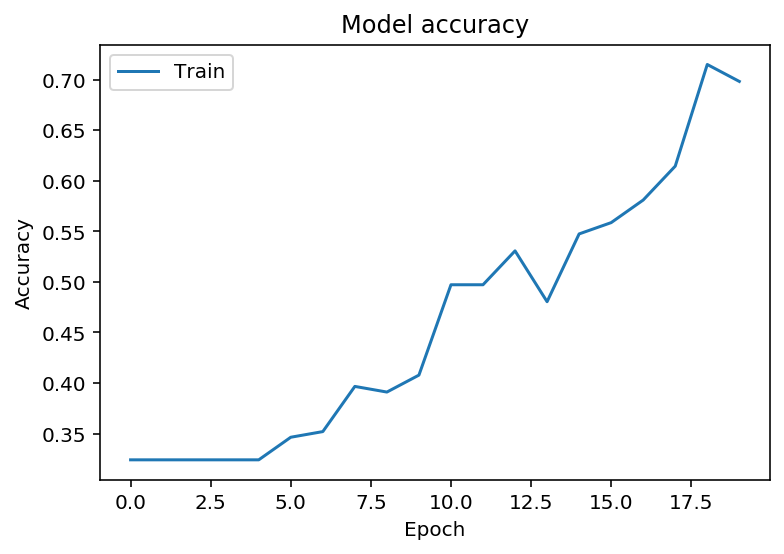

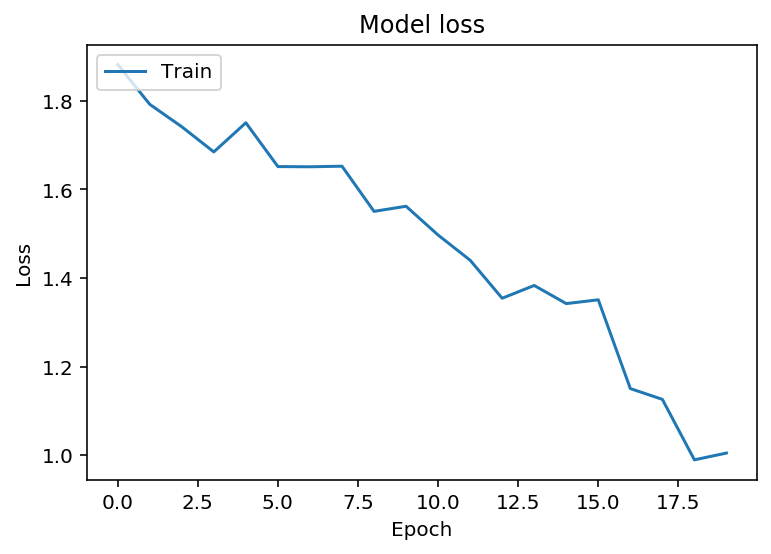

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
#classes = model.predict(x_test.values)
y_prob = model.predict(x_test)
y_classes = [1 if i[0]>=0.5 else 0 for i in y_prob]
print(y_classes)
#y_classes = y_prob.argmax(axis=-1)

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]


In [22]:
print(classification_report(y_test, y_classes))

              precision    recall  f1-score   support

         0.0       0.71      0.34      0.47        29
         1.0       0.39      0.75      0.51        16

    accuracy                           0.49        45
   macro avg       0.55      0.55      0.49        45
weighted avg       0.60      0.49      0.48        45



In [23]:
#!mkdir -p saved_model
#model.save('NN_predict_sim_model')
new_model = tf.keras.models.load_model('NN_predict_sim_model')

# Check its architecture
new_model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 128)               11136     
_________________________________________________________________
activation_113 (Activation)  (None, 128)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_227 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_228 (Dense)            (None, 1)                 33        
_________________________________________________________________
activation_114 (Activation)  (None, 1)                 0         
Total params: 31,809
Trainable params: 31,809
Non-trainable params: 0
_________________________________________________

In [24]:
#classes = model.predict(x_test.values)
y_prob_new = new_model.predict(x_test)
y_classes_new = [1 if i[0]>=0.5 else 0 for i in y_prob_new]
print(y_classes_new)
#y_classes = y_prob.argmax(axis=-1)

[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]


In [25]:
print(classification_report(y_test, y_classes_new))

              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77        29
         1.0       0.59      1.00      0.74        16

    accuracy                           0.76        45
   macro avg       0.80      0.81      0.76        45
weighted avg       0.86      0.76      0.76        45



In [26]:
def evaluate_similarity_df(folder_in, folder_out, scaler, model):
    '''This function evaluates the similarity of songs that are in a folder with certain structure,
    and removes the songs that are very similar from another identical folder.
    
    INPUTS:
    1) folder_in and 2) folder_out are identical, with the following structure:
    
    Each folder that contains a certain number of midi songs, where each song is divided in three parts.
    The similarity of Part_1 and Part_3 of each song will be compared, if similar, the 3 parts of that song
    will be removed from the folder_out (while folder_in will remain unmodified). Example:
    
                                    name_song_1.midi
                                    name_song_2.midi
                                    name_song_3.midi
                                    
    3) scaler: min_max_scaler used to rescale the training data before feeding the NN.
    Can be imported from preprocessing.MinMaxScaler() or downloaded from my github.
    
    4) model: model used to predict whether name_song_1.midi is similar to name_song_3.midi. Can be downloaded
    from my github.
    '''    
    directory_total = sorted(os.listdir(folder_in))
    min_max_scaler = scaler
    for k in range(1,len(directory_total)+1):
        if k%450==0:
            print(k-450, " - ",k-1,"\n")
            directory = sorted(os.listdir(folder_in))[k-450:k]
            #print(directory_10, "\n")
    
            # create empty arrays
            tempo = []
            onset_cov = []
            onset_var = []
            onset_std = []
            onset_mean = []
            onset_av = []
            onset_median = []
            onset_perc = []
            onset_ptp = []
            onset_max = []
            onset_min = []

            pitch_histogram = []
            pitch_histogram_cov = []
            pitch_histogram_var = []
            pitch_histogram_std = []
            pitch_histogram_mean = []
            pitch_histogram_av = []
            pitch_histogram_median = []
            pitch_histogram_perc = []
            pitch_histogram_ptp = []
            pitch_histogram_max = []
            pitch_histogram_min = []

            pitch_transition = []
            pitch_transition_cov = []
            pitch_transition_var =[]
            pitch_transition_std = []
            pitch_transition_mean = []
            pitch_transition_av = []
            pitch_transition_median = []
            pitch_transition_perc = []
            pitch_transition_ptp = []
            pitch_transition_max = []
            pitch_transition_min = []
            velocity = []
            key = []

            _tempo = []
            _onset_cov = []
            _onset_var = []
            _onset_std = []
            _onset_mean = []
            _onset_av = []
            _onset_median = []
            _onset_perc = []
            _onset_ptp = []
            _onset_max = []
            _onset_min = []

            _pitch_histogram = []
            _pitch_histogram_cov = []
            _pitch_histogram_var = []
            _pitch_histogram_std = []
            _pitch_histogram_mean = []
            _pitch_histogram_av = []
            _pitch_histogram_median = []
            _pitch_histogram_perc = []
            _pitch_histogram_ptp = []
            _pitch_histogram_max = []
            _pitch_histogram_min = []

            _pitch_transition = []
            _pitch_transition_cov = []
            _pitch_transition_var =[]
            _pitch_transition_std = []
            _pitch_transition_mean = []
            _pitch_transition_av = []
            _pitch_transition_median = []
            _pitch_transition_perc = []
            _pitch_transition_ptp = []
            _pitch_transition_max = []
            _pitch_transition_min = []
            _velocity = []
            _key = []

            #folder = 'lahk_midi_interpolation'
            #directory = sorted(os.listdir(folder_in))

            # make lst from directory folder
            lst = []
            for i in range(1,len(directory)+1):
                if i%3==0:
                    lst.append(directory[i-3])

            df = pd.DataFrame(data=lst, columns = ['name'])
            #directory = newest_list
            for i in range(1,len(directory)+1):
                if i%3==0:
                    song = directory[i-3]
                    print(song)
                    midi_data = pretty_midi.PrettyMIDI(folder_in+'/'+song)
                    onset_1 = midi_data.get_onsets()
                    pitch_histogram = midi_data.get_pitch_class_histogram(use_duration=True, use_velocity=True, normalize=True)
                    pitch_transition = midi_data.get_pitch_class_transition_matrix(normalize=True, time_thresh=0.05)

                    if midi_data.estimate_tempi()[0].size == 0: #will cause error
                        tempo.append(0)
                    else:
                        tempo.append(midi_data.estimate_tempo())
                    onset_cov.append(np.cov(onset_1))
                    onset_var.append(np.var(onset_1))
                    onset_std.append(np.std(onset_1))
                    onset_mean.append(np.mean(onset_1))
                    onset_av.append(np.average(onset_1))
                    onset_median.append(np.median(onset_1))
                    if(onset_1.shape==(0,)): #will cause error
                        #print("onset will cause error so we add 0 values for the next arrays")
                        onset_perc.append(0)
                        onset_ptp.append(0)
                        onset_max.append(0)
                        onset_min.append(0)
                    else:
                        onset_perc.append(np.percentile(onset_1,100))
                        onset_ptp.append(np.ptp(onset_1))
                        onset_max.append(np.amax(onset_1))
                        onset_min.append(np.amin(onset_1))

                    #pitch_histogram = (pitch_histogram)
                    pitch_histogram_cov.append(np.cov(pitch_histogram))
                    pitch_histogram_var.append(np.var(pitch_histogram))
                    pitch_histogram_std.append(np.std(pitch_histogram))
                    pitch_histogram_mean.append(np.mean(pitch_histogram))
                    pitch_histogram_av.append(np.average(pitch_histogram))
                    pitch_histogram_median.append(np.median(pitch_histogram))
                    pitch_histogram_perc.append(np.percentile(pitch_histogram,100))
                    pitch_histogram_ptp.append(np.ptp(pitch_histogram))
                    pitch_histogram_max.append(np.amax(pitch_histogram))
                    pitch_histogram_min.append(np.amin(pitch_histogram))

                    #pitch_transition = (pitch_transition)
                    pitch_transition_cov.append(np.cov(pitch_transition))
                    pitch_transition_var.append(np.var(pitch_transition))
                    pitch_transition_std.append(np.std(pitch_transition))
                    pitch_transition_mean.append(np.mean(pitch_transition))
                    pitch_transition_av.append(np.average(pitch_transition))
                    pitch_transition_median.append(np.median(pitch_transition))
                    pitch_transition_perc.append(np.percentile(pitch_transition,100))
                    pitch_transition_ptp.append(np.ptp(pitch_transition))
                    pitch_transition_max.append(np.amax(pitch_transition))
                    pitch_transition_min.append(np.amin(pitch_transition))

                    total_velocity = sum(sum(midi_data.get_chroma()))
                    #print('tot vel 1:',total_velocity)
                    if total_velocity == 0: #will cause error
                        velocity.append(total_velocity)
                        key.append([0 for semitone in midi_data.get_chroma()])
                    else:
                        velocity.append(total_velocity)
                        key.append([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

                    #print('append of 1st song done')
                    #print(i)
                    #print()

                    song = directory[i-1]
                    print(song)
                    midi_data = pretty_midi.PrettyMIDI(folder_in+'/'+song)
                    onset_1 = midi_data.get_onsets()
                    pitch_histogram = midi_data.get_pitch_class_histogram(use_duration=True, use_velocity=True, normalize=True)
                    pitch_transition = midi_data.get_pitch_class_transition_matrix(normalize=True, time_thresh=0.05)

                    if midi_data.estimate_tempi()[0].size == 0: #will cause error
                        _tempo.append(0)
                    else:
                        _tempo.append(midi_data.estimate_tempo())
                    #tempo.append(midi_data.estimate_tempo())
                    _onset_cov.append(np.cov(onset_1))
                    _onset_var.append(np.var(onset_1))
                    _onset_std.append(np.std(onset_1))
                    _onset_mean.append(np.mean(onset_1))
                    _onset_av.append(np.average(onset_1))
                    _onset_median.append(np.median(onset_1))
                    if(onset_1.shape==(0,)): #will cause error
                        #print("onset will cause error so we add 0 values for the next arrays")
                        _onset_perc.append(0)
                        _onset_ptp.append(0)
                        _onset_max.append(0)
                        _onset_min.append(0)
                    else:
                        _onset_perc.append(np.percentile(onset_1,100))
                        _onset_ptp.append(np.ptp(onset_1))
                        _onset_max.append(np.amax(onset_1))
                        _onset_min.append(np.amin(onset_1))

                    #pitch_histogram = (pitch_histogram)
                    _pitch_histogram_cov.append(np.cov(pitch_histogram))
                    _pitch_histogram_var.append(np.var(pitch_histogram))
                    _pitch_histogram_std.append(np.std(pitch_histogram))
                    _pitch_histogram_mean.append(np.mean(pitch_histogram))
                    _pitch_histogram_av.append(np.average(pitch_histogram))
                    _pitch_histogram_median.append(np.median(pitch_histogram))
                    _pitch_histogram_perc.append(np.percentile(pitch_histogram,100))
                    _pitch_histogram_ptp.append(np.ptp(pitch_histogram))
                    _pitch_histogram_max.append(np.amax(pitch_histogram))
                    _pitch_histogram_min.append(np.amin(pitch_histogram))

                    #pitch_transition = (pitch_transition)
                    _pitch_transition_cov.append(np.cov(pitch_transition))
                    _pitch_transition_var.append(np.var(pitch_transition))
                    _pitch_transition_std.append(np.std(pitch_transition))
                    _pitch_transition_mean.append(np.mean(pitch_transition))
                    _pitch_transition_av.append(np.average(pitch_transition))
                    _pitch_transition_median.append(np.median(pitch_transition))
                    _pitch_transition_perc.append(np.percentile(pitch_transition,100))
                    _pitch_transition_ptp.append(np.ptp(pitch_transition))
                    _pitch_transition_max.append(np.amax(pitch_transition))
                    _pitch_transition_min.append(np.amin(pitch_transition))

                    total_velocity = sum(sum(midi_data.get_chroma()))
                    #print('tot vel 2:',total_velocity)
                    if total_velocity == 0: #will cause error
                        _velocity.append(total_velocity)
                        _key.append([0 for semitone in midi_data.get_chroma()])
                    else:
                        _velocity.append(total_velocity)
                        _key.append([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

                    print('\n')

            #print("tempo: ", "\n", tempo, "\n", len(tempo))

            df.insert(1, "tempo", tempo, True)
            df.insert(2, "onset_cov", onset_cov, True)
            df.insert(3, "onset_var", onset_var, True)
            df.insert(4, "onset_std", onset_std, True)
            df.insert(5, "onset_mean", onset_mean, True)
            df.insert(6, "onset_av", onset_av, True)
            df.insert(7, "onset_median", onset_median, True)
            df.insert(8, "onset_perc", onset_perc, True)
            df.insert(9, "onset_ptp", onset_ptp, True)
            df.insert(10, "onset_max", onset_max, True)
            df.insert(11, "onset_min", onset_min, True)

            #df.insert(12, "pitch_histogram", pitch_histogram, True)
            df.insert(12, "pitch_histogram_cov", pitch_histogram_cov, True)
            df.insert(13, "pitch_histogram_var", pitch_histogram_var, True)
            df.insert(14, "pitch_histogram_std", pitch_histogram_std, True)
            df.insert(15, "pitch_histogram_mean", pitch_histogram_mean, True)
            df.insert(16, "pitch_histogram_av", pitch_histogram_av, True)
            df.insert(17, "pitch_histogram_median", pitch_histogram_median, True)
            df.insert(18, "pitch_histogram_perc", pitch_histogram_perc, True)
            df.insert(19, "pitch_histogram_ptp", pitch_histogram_ptp, True)
            df.insert(20, "pitch_histogram_max", pitch_histogram_max, True)
            df.insert(21, "pitch_histogram_min", pitch_histogram_min, True)

            #df.insert(23, "pitch_transition", pitch_transition, True)
            df.insert(22, "pitch_transition_cov", pitch_transition_cov, True)
            df.insert(23, "pitch_transition_var", pitch_transition_var, True)
            df.insert(24, "pitch_transition_std", pitch_transition_std, True)
            df.insert(25, "pitch_transition_mean", pitch_transition_mean, True)
            df.insert(26, "pitch_transition_av", pitch_transition_av, True)
            df.insert(27, "pitch_transition_median", pitch_transition_median, True)
            df.insert(28, "pitch_transition_perc", pitch_transition_perc, True)
            df.insert(29, "pitch_transition_ptp", pitch_transition_ptp, True)
            df.insert(30, "pitch_transition_max", pitch_transition_max, True)
            df.insert(31, "pitch_transition_min", pitch_transition_min, True)

            df.insert(32, "_tempo", _tempo, True)
            df.insert(33, "_onset_cov", _onset_cov, True)
            df.insert(34, "_onset_var", _onset_var, True)
            df.insert(35, "_onset_std", _onset_std, True)
            df.insert(36, "_onset_mean", _onset_mean, True)
            df.insert(37, "_onset_av", _onset_av, True)
            df.insert(38, "_onset_median", _onset_median, True)
            df.insert(39, "_onset_perc", _onset_perc, True)
            df.insert(40, "_onset_ptp", _onset_ptp, True)
            df.insert(41, "_onset_max", _onset_max, True)
            df.insert(42, "_onset_min", _onset_min, True)

            #df.insert(12, "pitch_histogram", pitch_histogram, True)
            df.insert(43, "_pitch_histogram_cov", _pitch_histogram_cov, True)
            df.insert(44, "_pitch_histogram_var", _pitch_histogram_var, True)
            df.insert(45, "_pitch_histogram_std", _pitch_histogram_std, True)
            df.insert(46, "_pitch_histogram_mean", _pitch_histogram_mean, True)
            df.insert(47, "_pitch_histogram_av", _pitch_histogram_av, True)
            df.insert(48, "_pitch_histogram_median", _pitch_histogram_median, True)
            df.insert(49, "_pitch_histogram_perc", _pitch_histogram_perc, True)
            df.insert(50, "_pitch_histogram_ptp", _pitch_histogram_ptp, True)
            df.insert(51, "_pitch_histogram_max", _pitch_histogram_max, True)
            df.insert(52, "_pitch_histogram_min", _pitch_histogram_min, True)

            #df.insert(23, "pitch_transition", pitch_transition, True)
            df.insert(53, "_pitch_transition_cov", _pitch_transition_cov, True)
            df.insert(54, "_pitch_transition_var", _pitch_transition_var, True)
            df.insert(55, "_pitch_transition_std", _pitch_transition_std, True)
            df.insert(56, "_pitch_transition_mean", _pitch_transition_mean, True)
            df.insert(57, "_pitch_transition_av", _pitch_transition_av, True)
            df.insert(58, "_pitch_transition_median", _pitch_transition_median, True)
            df.insert(59, "_pitch_transition_perc", _pitch_transition_perc, True)
            df.insert(60, "_pitch_transition_ptp", _pitch_transition_ptp, True)
            df.insert(61, "_pitch_transition_max", _pitch_transition_max, True)
            df.insert(62, "_pitch_transition_min", _pitch_transition_min, True)

            df.insert(63, "velocity", velocity, True)
            df.insert(64, "key", key, True)
            df.insert(65, "_velocity", _velocity, True)
            df.insert(66, "_key", _key, True)

            #-------- create extra columns with information of pitch histograms, onsets and keys-----------
            a =[]
            b=[]
            for i in range(0,12):
                for j in range(0,12):
                    #print(df['pitch_transition_cov'][0][i][j])
                    a.append(df['pitch_transition_cov'][0][i][j])
            for i in range(0,12):
                for j in range(0,12):
                    #print(df['pitch_transition_cov'][0][i][j])
                    b.append(df['pitch_transition_cov'][1][i][j])
            arr = np.array(a)
            (arr[132])
            arr.reshape(12,12)
            df_arr = pd.DataFrame(data=arr)#, index=["row1", "row2"], columns=["column1", "column2"])
            df_arr['1'] = b

            #pitch histogram covariance: 245x1
            df_ph1 = pd.DataFrame([df['pitch_histogram_cov'][i] for i in range(0,len(df))])
            df_ph2 = pd.DataFrame([df['_pitch_histogram_cov'][i] for i in range(0,len(df))])
            df_ph = pd.merge(df_ph1, df_ph2, left_index=True, right_index=True)

            #onset covariance 245x1
            df_onset1 = pd.DataFrame([df['onset_cov'][i] for i in range(0,len(df))])
            df_onset2 = pd.DataFrame([df['_onset_cov'][i] for i in range(0,len(df))])
            df_onset = pd.merge(df_onset1, df_onset2, left_index=True, right_index=True)

            #pitch transition covariance: 245x12x12
            df_pt1 = pd.DataFrame([df['pitch_transition_cov'][i][j][k] for i in range(0,len(df))
                                                        for j in range(0,len(df['pitch_transition_cov'][0]))
                                                        for k in range(0,len(df['pitch_transition_cov'][0][0]))])
            #key
            df_key1 = pd.DataFrame([df['key'][i] for i in range(0,len(df))])
            df_key2 = pd.DataFrame([df['_key'][i] for i in range(0,len(df))])
            df_key = pd.merge(df_key1, df_key2, left_index=True, right_index=True)

            #merge datasets
            df_ph = pd.merge(df_ph, df_onset, left_index=True, right_index=True)
            df_ph = pd.merge(df_ph, df_key, left_index=True, right_index=True)

            df = pd.merge(df, df_ph, left_index=True, right_index=True)

            # identify rows than contain NaN values and drop them
            nan_values_counter = 0
            nan_rows = []
            for index, row in df.iterrows():
                drop = False
                for i in range(len(row)):
                    if str(row[i]) == 'nan':
                        nan_values_counter+=1
                        #df = df.drop([index])
                        drop = True
                if drop == True:
                    nan_rows.append(index)
            #print(nan_rows)
            df = df.drop(nan_rows)

            #drop some original columns once we have extracted all its features and appended them to df
            df.drop(columns='pitch_histogram_cov', inplace=True) #--
            df.drop(columns='_pitch_histogram_cov', inplace=True) #--
            df.drop(columns='onset_cov', inplace=True) #--
            df.drop(columns='_onset_cov', inplace=True) #--
            df.drop(columns='pitch_transition_cov', inplace=True)
            df.drop(columns='_pitch_transition_cov', inplace=True)
            df.drop(columns='key', inplace=True)
            df.drop(columns='_key', inplace=True)
            df_names = df.copy()
            df.drop(columns='name', inplace=True)

            # ---------- min max scaling of the data ------------------
            x = df.values #returns a numpy array
            #min_max_scaler = preprocessing.MinMaxScaler() #min_max_scaler values taken from training data
            x_scaled = min_max_scaler.fit_transform(x)
            df = pd.DataFrame(x_scaled)
            df = df.reset_index(drop=True)
            df_names = df_names.reset_index(drop=True)
            df_names

            #---------------------------------------------------------------------------------
            # UNTIL NOW WE HAVE:
            # df
            # df_names
            # lst

            #return df_names, df, lst
            #---------------------------------------------------------------------------------
            # MODEL TO EVALUATE the similarity of songs in the dataframe
            y_prob_new = new_model.predict(df.iloc[:])
            y_classes_new = [1 if i[0]>=0.5 else 0 for i in y_prob_new]
            #print(y_classes_new)
            #len(y_classes_new)
            for i in range(0,len(df_names)): # remove similar songs
                if y_classes_new[i]==0:
                    name_song_to_remove = df_names['name'][i]
                    name_song_to_remove = name_song_to_remove[:len(name_song_to_remove)-6]
                    remove_1 = name_song_to_remove + "1.midi"
                    remove_2 = name_song_to_remove + "2.midi"
                    remove_3 = name_song_to_remove + "3.midi"
                    os.remove(folder_out+"/"+remove_1)
                    #print(i, " ", remove_1, " removed")
                    os.remove(folder_out+"/"+remove_2)
                    #print(i, " ", remove_2, " removed")
                    os.remove(folder_out+"/"+remove_3)
                    print(i, " ", remove_1, " removed 1_2_3")
        
    return df_names, df, lst, y_classes_new;

In [ ]:
# test to ensure that previous function works well in a small dataset (around 900 songs)
df_names, df, lst, y_classes_new = evaluate_similarity_df('total_midi_10s_after_similarity_ev_in',
                                                          'total_midi_10s_after_similarity_ev_out',
                                                          min_max_scaler)

In [ ]:
df_names, df, lst, y_classes_new = evaluate_similarity_df('total_midi_10s',
                                                          'total_midi_10s (4th copy)',
                                                          min_max_scaler)

In [39]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", class_weight={1:5})

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6
              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72        29
         1.0       0.40      0.25      0.31        16

    accuracy                           0.60        45
   macro avg       0.53      0.52      0.51        45
weighted avg       0.57      0.60      0.57        45

Recall: 0.25


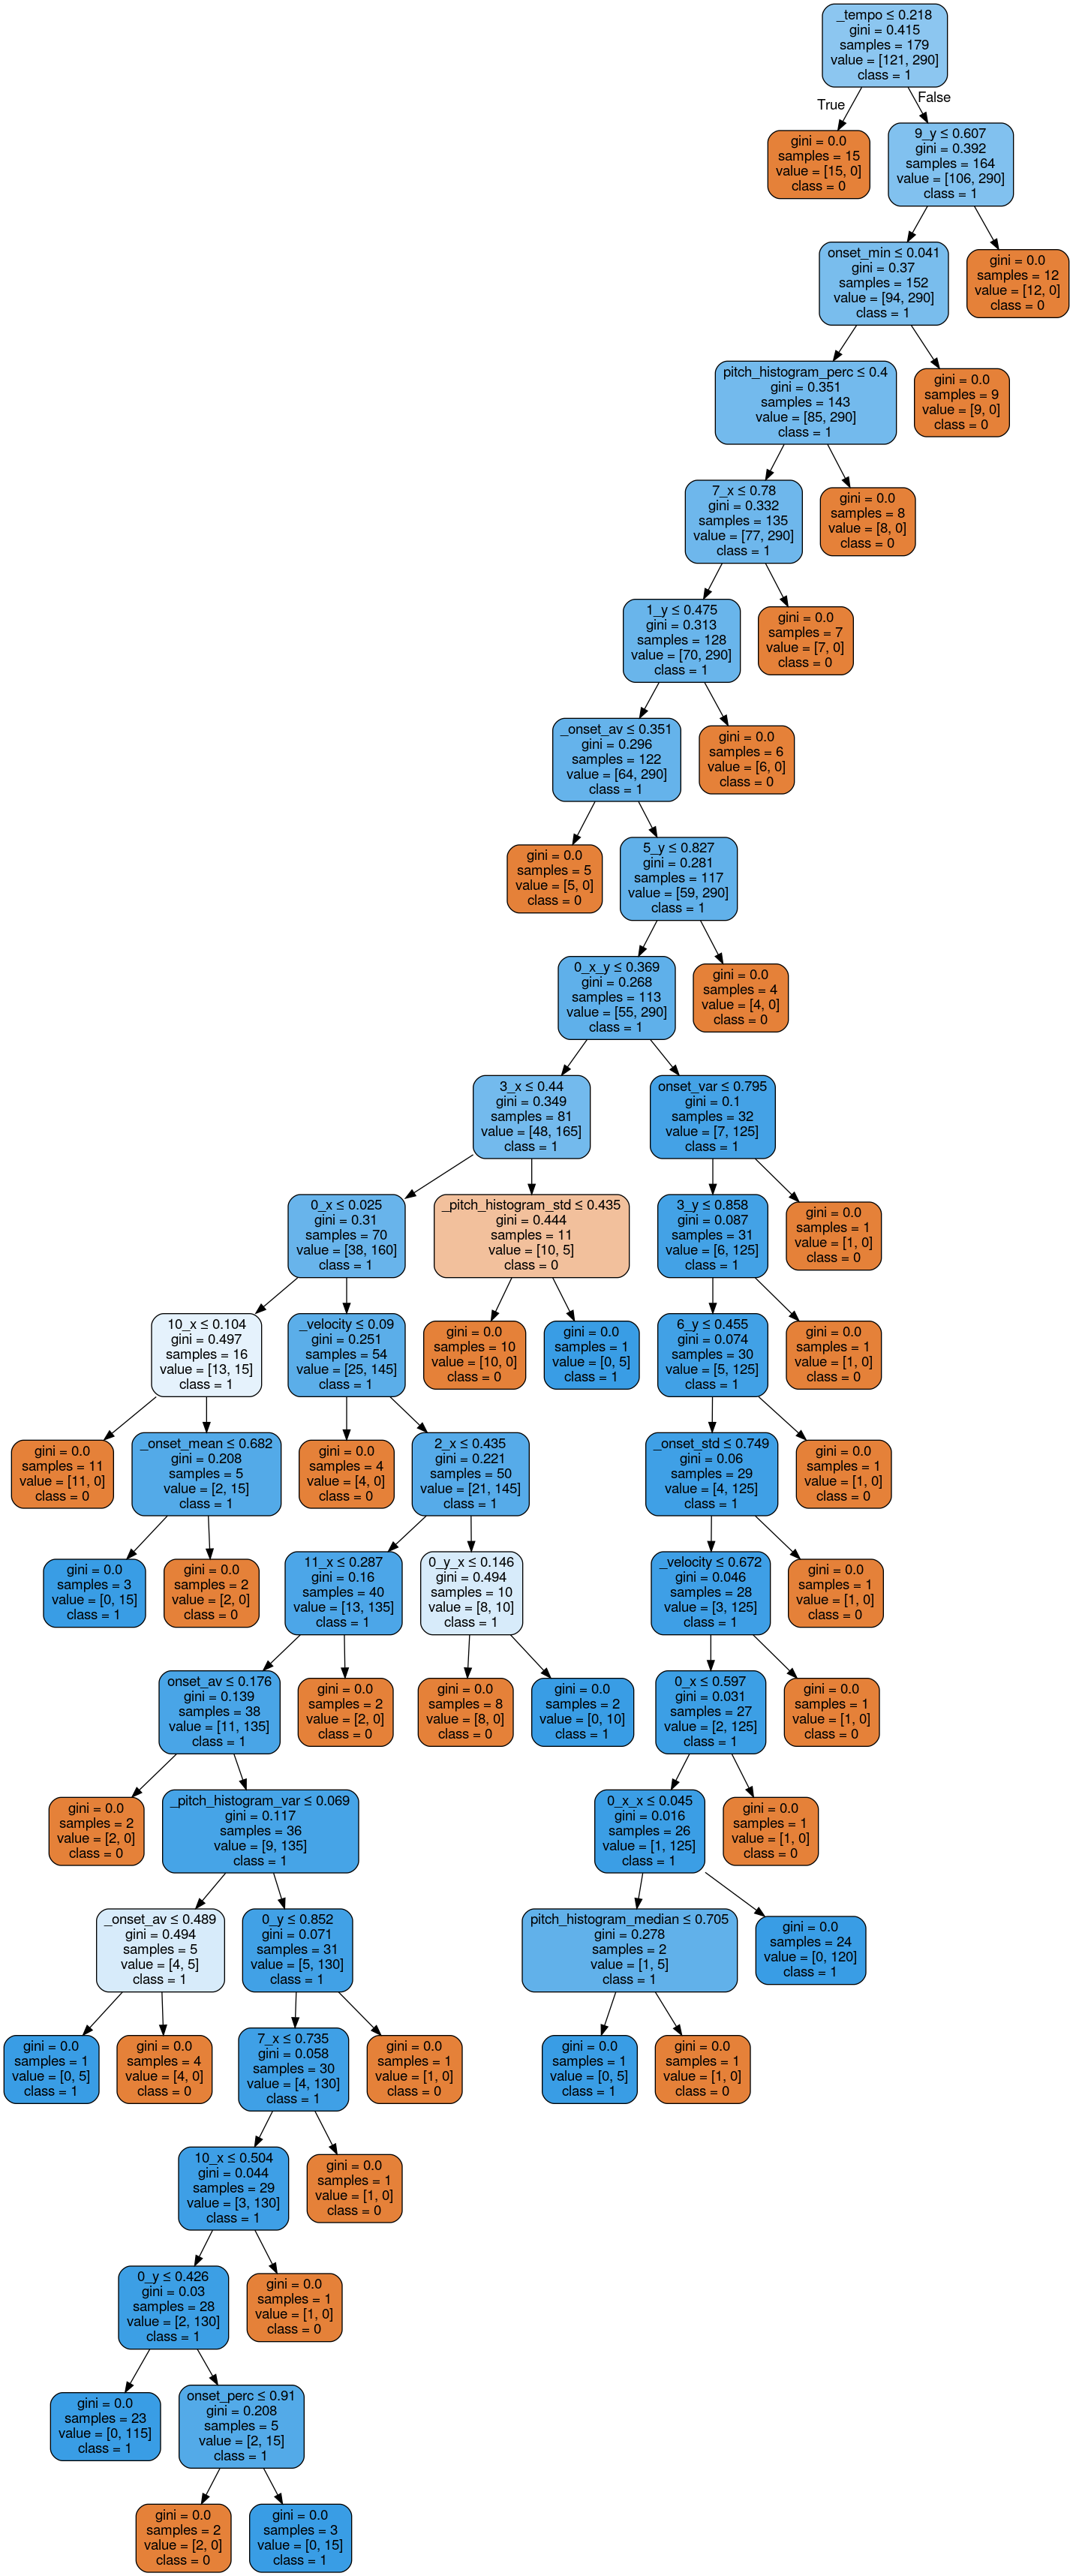

In [40]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = col_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [41]:
logreg = LogisticRegression(penalty='l2', class_weight={0: 1, 1: 3.5}) # 1 vs 2.7
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 3.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.53


In [43]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[13 16]
 [ 5 11]]


In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.45      0.55        29
         1.0       0.41      0.69      0.51        16

    accuracy                           0.53        45
   macro avg       0.56      0.57      0.53        45
weighted avg       0.61      0.53      0.54        45



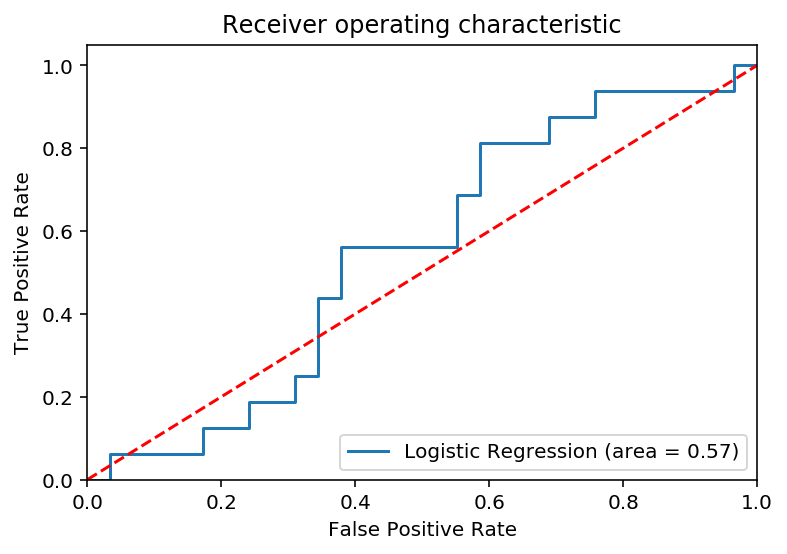

In [45]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()